# 目的
- 事後分布に基づいて、エンゼルが当たるまでの購入数を見積もる

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import pymc as pm

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

import scipy.stats as stats

import ChocoUtils as cu

## データを取得する
- 金のエンゼル2倍キャンペーンを除いた期間のデータを集計する

In [2]:
data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="campaign is not 1")
data.groupby(['angel']).count()

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE campaign is not 1;
Shape of MeasurementData(record_num, n_columns) : (121, 14)


,measure_date,best_before,prd_number,weight,box_weight,ball_number,factory,shop,campaign,taste,buyer,net_weight,mean_weight
angel,,,,,,,,,,,,,
0,114,114,114,114,114,114,114,114,114,114,114,114,114
1,7,7,7,7,7,7,7,7,7,7,7,7,7


## エンゼル出現確率の予測

In [3]:
def getMCMCResult(data, n_sample=15000, n_burn=5000):
    """
    MCMCでエンゼルの出現確率を予測する
    Args:
        data:エンゼルの観測結果(array)
        n_sample:MCMCシミュレーションの回数(integer)
        n_burn:捨てる数(integer)
    """
    # 出現確率pの事前分布
    p = pm.Uniform('p', lower=0, upper=1)
    # 観測を結びつける
    obs = pm.Bernoulli('obs', p, value=data, observed=True)

    # MCMC
    # Modelオブジェクト生成
    model = pm.Model([p, obs])
    mcmc = pm.MCMC(model)
    mcmc.sample(n_sample, n_burn)

    return mcmc.trace('p')[:]

In [4]:
# 銀のエンゼル
data_angel = np.array([1 if a == 1 else 0 for a in data['angel'].values])
p_trace_s = getMCMCResult(data_angel)

# 金のエンゼル
data_angel = np.array([1 if a == 2 else 0 for a in data['angel'].values])
p_trace_g = getMCMCResult(data_angel)

 [-----------------100%-----------------] 15000 of 15000 complete in 0.4 sec

95% BayesCredibleInterval : 0.03328026251061941-0.10605949131772727
ExpectedValue : 0.06467525532497181
95% BayesCredibleInterval : 0.00040837737828894674-0.023035255649678295
ExpectedValue : 0.007841391738461517


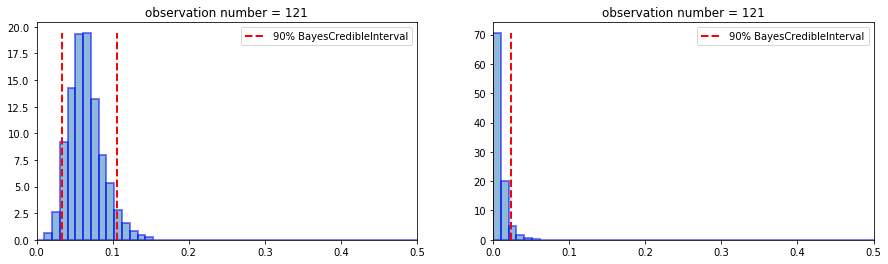

In [5]:
def pltAngelRate(p_trace, ax):
    ret = ax.hist(p_trace, bins=np.linspace(0, 0.5, 50), density=True, alpha=0.5, edgecolor="#0000FF", lw=2)
    ax.set_xlim([0, 0.5])
    N = len(p_trace)
    bci_g = np.sort(p_trace)[int(N * 0.95)]
    bci_l = np.sort(p_trace)[int(N * 0.05)]
    ax.vlines(x=bci_g, ymin=0, ymax=ret[0].max(),
              label='90% BayesCredibleInterval',
              color='red', linestyles='--', linewidths=2)
    ax.vlines(x=bci_l, ymin=0, ymax=ret[0].max(),
              color='red', linestyles='--', linewidths=2)
    ax.legend(loc="upper right")
    ax.set_title('observation number = %d' % (len(data_angel)))
    print('95% BayesCredibleInterval : {}-{}'.format(bci_l, bci_g))
    print('ExpectedValue : {}'.format(p_trace.mean()))
    return (bci_l, bci_g)

fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1, 2)
bci_silver = pltAngelRate(p_trace=p_trace_s, ax=ax[0])
bci_gold = pltAngelRate(p_trace=p_trace_g, ax=ax[1])

## エンゼルがn個当たるまでの数の予測
- MCMCサンプルを使って積分を数値計算する

In [6]:
def getExpect(p_trace, n, ks):
    pmf_arr = np.array(list(map(lambda p:stats.nbinom.pmf(ks, n, p), p_trace)))
    pmf_expect = pmf_arr.mean(axis=0)
    cdf_expect = (pmf_arr.cumsum(axis=1)).mean(axis=0)
    
    first_over_50 = list(cdf_expect).index(cdf_expect[cdf_expect>0.5].min())
    print("50% Over : ", first_over_50)
    
    fig = plt.figure(figsize=(13, 4))
    ax = fig.subplots(1, 2)
    
    ax[0].plot(ks, pmf_expect)
    ax[0].set_title('Probability Mass Function')
    ax[0].set_xlabel('False Count')
    ax[0].set_ylabel('Probability Mass')
    ax[1].plot(ks, cdf_expect)
    ax[1].set_title('Cumulative Probability Mass Function')
    ax[1].set_xlabel('False Count')
    ax[1].set_ylabel('Cum. Probability')
    ax[1].set_ylim([0.0, 1.0])
    ax[1].vlines(x=first_over_50, ymin=0, ymax=1.0, color="red", label="50% Over")
    
    return 0

### 銀のエンゼル

50% Over :  70


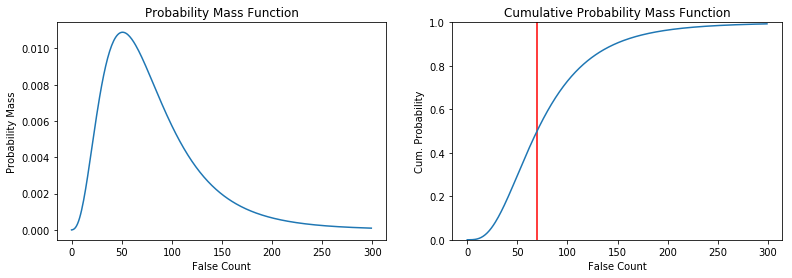

In [7]:
n = 5
ks = np.arange(0,300,1) # n回成功するまでの失敗回数

ret = getExpect(p_trace_s, n, ks)


### 金のエンゼル

50% Over :  129


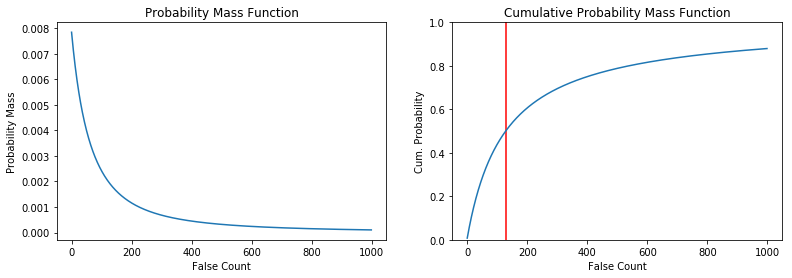

In [8]:
n = 1
ks = np.arange(0,1000,1) # n回成功するまでの失敗回数

ret = getExpect(p_trace_g, n, ks)


## 点推定した場合

In [9]:
def getExpectPoint(p, n, ks):
    pmf_expect = stats.nbinom.pmf(ks, n, p)
    cdf_expect = pmf_expect.cumsum()
    
    first_over_50 = list(cdf_expect).index(cdf_expect[cdf_expect>0.5].min())
    print("50% Over : ", first_over_50)
    
    fig = plt.figure(figsize=(13, 4))
    ax = fig.subplots(1, 2)
    
    ax[0].plot(ks, pmf_expect)
    ax[0].set_title('Probability Mass Function')
    ax[0].set_xlabel('False Count')
    ax[0].set_ylabel('Probability Mass')
    ax[1].plot(ks, cdf_expect)
    ax[1].set_title('Cumulative Probability Mass Function')
    ax[1].set_xlabel('False Count')
    ax[1].set_ylabel('Cum. Probability')
    ax[1].set_ylim([0.0, 1.0])
    ax[1].vlines(x=first_over_50, ymin=0, ymax=1.0, color="red", label="50% Over")
    
    return 0

50% Over :  76


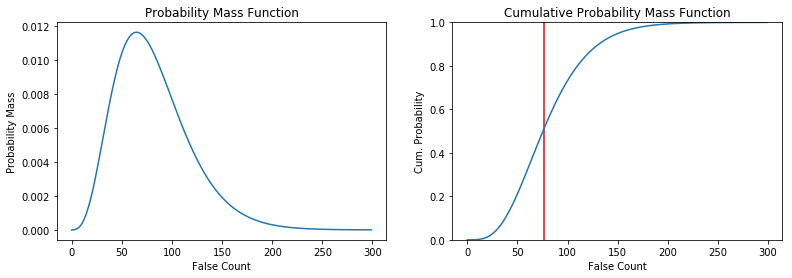

In [10]:
n = 5
ks = np.arange(0,300,1) # n回成功するまでの失敗回数
p = 7.0/121.0

ret = getExpectPoint(p, n, ks)


50% Over :  494


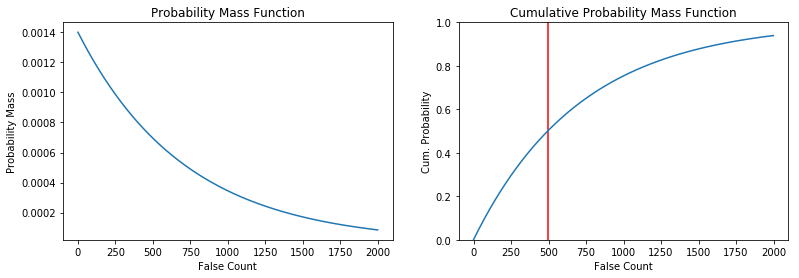

In [11]:
n = 1
ks = np.arange(0,2000,1) # n回成功するまでの失敗回数
p = 0.0014

ret = getExpectPoint(p, n, ks)